In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip3 install unidecode

     |████████████████████████████████| 245kB 33.5MB/s 


In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from unidecode import unidecode
import re
import pandas as pd
from copy import deepcopy
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Input, Dropout, GRU
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model

# Data preprocessing

> The dataset can be downloaded from https://github.com/philipperemy/name-dataset



In [0]:
file = open('your-path/first_names.all.txt', 'r')
data = file.read()
file.close()

In [0]:
data = data.lower()
data = unidecode(data)
data = re.sub('[^a-z\n]+', '', data)
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)

In [32]:
data_V2 = deepcopy(data)
data_V2 = data_V2.split('\n')
data_V2[:10]

['',
 'aisha',
 'aishah',
 'ajay',
 'aaisha',
 'aaishah',
 'aaban',
 'aabas',
 'aabha',
 'aabia']

In [33]:
print('There are %d total characters and %d unique characters.' % (data_size, vocab_size))


There are 1278347 total characters and 27 unique characters.


In [0]:
char_to_idx = { ch:i for i,ch in enumerate(sorted(chars)) }
idx_to_char = { i:ch for i,ch in enumerate(sorted(chars)) }

In [35]:
df_names = pd.DataFrame({'Character' : [], 'No.examples' : []})

for idx, char in idx_to_char.items():
  count = sum(map(lambda x : x.startswith(char), data_V2))
  df_names.loc[idx] = [char, int(count)]

df_names.head(10)

,Character,No.examples
0,\n,0.0
1,a,15791.0
2,b,7713.0
3,c,9539.0
4,d,9930.0
5,e,6247.0
6,f,3569.0
7,g,5608.0
8,h,5468.0
9,i,2930.0


### Distribution of names starting with a certain character

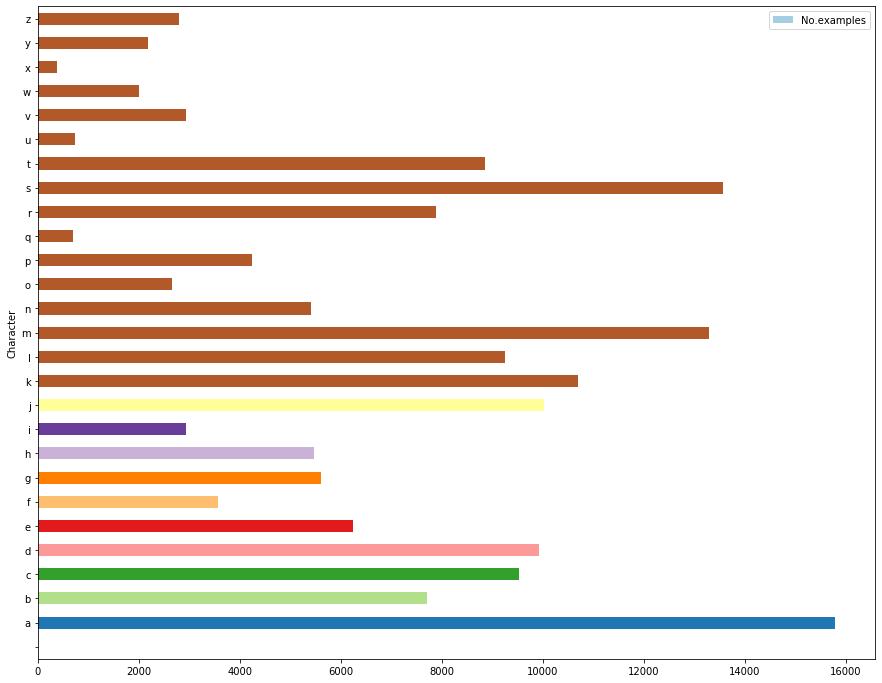

In [36]:
df_names.plot(x = 'Character', y = 'No.examples',kind = 'barh', figsize = (15,12), color=plt.cm.Paired(np.arange(len(df_names))))

In [0]:
data_V3 = []
for idx, char in idx_to_char.items():
  l = list(map(lambda x : x.startswith(char), data_V2))
  #count = sum(np.array(l) == True)
  #if count >= 2000:
  data_V3.extend(list(np.array(data_V2, dtype = object)[l]))




In [38]:
len(data_V3)

164432

### Since i'm using teacher forcing (the network is trained to predict the next characters of the target sequence, given previous characters of the target sequence), the target data is the same as input data, but offset by one (i.e. $y[i] = X[i+1]$) containing an "end" character (represented by \\n) at the end of each name, also the first character in each example from the input data is the "start" character (which i'll encode it as a vector of zeroes).

In [0]:
X, y = [],[]

for name in data_V3:
  seq = [char_to_idx[n] for n in name]
  X.append(seq)
  y.append(seq + [char_to_idx['\n']])

In [40]:
X = np.array(X)
y = np.array(y)
print("X shape: {}\ny shape: {}".format(X.shape,y.shape))

X shape: (164432,)
y shape: (164432,)


In [0]:
X = pad_sequences(X, padding = 'post')
X = to_categorical(X, num_classes = vocab_size)
y = pad_sequences(y, padding = 'post')
y = to_categorical(y, num_classes = vocab_size)

In [42]:
print("X shape: {}\ny shape: {}".format(X.shape,y.shape))

X shape: (164432, 22, 27)
y shape: (164432, 23, 27)


In [0]:
X = X.reshape(X.shape[0],vocab_size,X.shape[1])
#y = y.reshape(y.shape[0],vocab_size,y.shape[1])

### Add "start" character (encoded as a vector of zeroes) to all examples from the input data

In [0]:
start = np.zeros((vocab_size,1))
X_new = []
for i in range(X.shape[0]):
  X_new.append(np.c_[start,X[i]])
X_new = np.array(X_new)

In [0]:
X_new = X_new.reshape(X_new.shape[0],X_new.shape[2],X_new.shape[1])

In [46]:
print("X shape: {}\ny shape: {}".format(X_new.shape,y.shape))


X shape: (164432, 23, 27)
y shape: (164432, 23, 27)


#Model

### Architecture - 2 lstm layers + dense layer for classification











In [0]:
latent_dim = 50

decoder_inputs = Input(shape=(None, vocab_size))

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs)
decoder_outputs = Dropout(rate = 0.5)(decoder_outputs)

decoder_lstm_2 = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs_2, _, _ = decoder_lstm_2(decoder_outputs)
decoder_outputs_2 =  Dropout(rate = 0.5)(decoder_outputs_2)

decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs_2 = decoder_dense(decoder_outputs_2)

In [0]:
model = Model(decoder_inputs, decoder_outputs_2)

In [70]:
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, None, 27)          0         
_________________________________________________________________
lstm_9 (LSTM)                [(None, None, 50), (None, 15600     
_________________________________________________________________
dropout_8 (Dropout)          (None, None, 50)          0         
_________________________________________________________________
lstm_10 (LSTM)               [(None, None, 50), (None, 20200     
_________________________________________________________________
dropout_9 (Dropout)          (None, None, 50)          0         
_________________________________________________________________
dense_4 (Dense)              (None, None, 27)          1377      
Total params: 37,177
Trainable params: 37,177
Non-trainable params: 0
_______________________________________________________

In [71]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.fit(X_new, y,
          batch_size=256,
          epochs=20,
          shuffle=True)

Epoch 1/20
164432/164432 [==============================] - 48s 294us/step - loss: 0.9286
Epoch 2/20
164432/164432 [==============================] - 45s 274us/step - loss: 0.5841
Epoch 3/20
164432/164432 [==============================] - 46s 279us/step - loss: 0.4018
Epoch 4/20
164432/164432 [==============================] - 46s 277us/step - loss: 0.3222
Epoch 5/20
164432/164432 [==============================] - 45s 275us/step - loss: 0.2782
Epoch 6/20
164432/164432 [==============================] - 46s 280us/step - loss: 0.2487
Epoch 7/20
164432/164432 [==============================] - 46s 279us/step - loss: 0.2259
Epoch 8/20
164432/164432 [==============================] - 46s 283us/step - loss: 0.2076
Epoch 9/20
164432/164432 [==============================] - 46s 277us/step - loss: 0.1936
Epoch 10/20
164432/164432 [==============================] - 45s 276us/step - loss: 0.1818
Epoch 11/20
164432/164432 [==============================] - 46s 280us/step - loss: 0.1727
Epoch 12

### Inference setup




In [0]:

decoder_state_input_h1 = Input(shape=(latent_dim,))
decoder_state_input_c1 = Input(shape=(latent_dim,))

decoder_state_input_h2 = Input(shape=(latent_dim,))
decoder_state_input_c2 = Input(shape=(latent_dim,))

decoder_states_inputs = [decoder_state_input_h1, decoder_state_input_c1,
                         decoder_state_input_h2, decoder_state_input_c2]

decoder_outputs, state_h1, state_c1 = decoder_lstm(decoder_inputs, 
                                                   initial_state=decoder_states_inputs[:2])

decoder_outputs, state_h2, state_c2 = decoder_lstm_2(decoder_outputs, 
                                                   initial_state=decoder_states_inputs[-2:])


decoder_states = [state_h1, state_c1, state_h2, state_c2]


decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

### Decoding function - generate + decode indexes into text

In [0]:
def decode_sequence():
  
    states_value = [np.zeros((1,latent_dim)), np.random.randn(1,latent_dim),
                    np.zeros((1,latent_dim)), np.random.randn(1,latent_dim)]

    target_seq = np.zeros((1, 1, vocab_size))
 

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c, h1, c1 = decoder_model.predict([target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx_to_char[sampled_token_index]
        decoded_sentence += sampled_char

 
        if (sampled_char == '\n' or
           len(decoded_sentence) > 50):
            stop_condition = True

        target_seq = np.zeros((1, 1, vocab_size))
        target_seq[0, 0, sampled_token_index] = 1.
        states_value = [h, c, h1, c1]

    return decoded_sentence

In [87]:
for _ in range(20):
  print(decode_sequence())

tsplg

ooonnmjgd

yuspnie

yusojd

tutsolg

utoh

sroke

srplgc

eedaaa

ywusojd

nmlic

srplg

brrrroonlie

zwrle

srrpomie

ttoke

roic

vsrnha

iiheaa

soke



# Conclusion

> The output of the neural network doesn't seem so great, however we can observe that some of the generated names are quite readable (i.e. the combination of vowels and consonants are alligned in such a way that we could easily pronounce the generated name), so that's a positive thing. One thing i could try is to use GRU's instead of LSTM's since the latter are used for long term dependencies that span many characters in the text, and it doesn't help too much in this case since the names in the dataset are quite short.

